<a href="https://colab.research.google.com/github/orbenishay/Classification/blob/master/Shares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Number of shares in social networks**

https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Online%20News%20Popularity

In [0]:
# import modules
# General tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import warnings

# Pandas
from datetime import datetime
from datetime import timedelta



# Pipieline summarized:
from scipy.optimize import curve_fit# For curve fitting
from sklearn.base import TransformerMixin # For transformations and predictions
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator # For predictions
from sklearn.metrics import mean_squared_log_error as msle # For scoring
from sklearn.metrics import mean_squared_error as mse # For scoring
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
import pydot as pyd # For the tree visualization
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn.model_selection import train_test_split # For validation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, accuracy_score # For classification
from sklearn.metrics import precision_score, recall_score, f1_score # For classification
from sklearn.metrics import log_loss # For classification

!pip install pydot

import sys

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### **Load files (dataset and dictionary)**

In [0]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import files
    uploaded = files.upload()

Saving Shares_Cat.csv to Shares_Cat.csv


### **Create dadtaframe**

In [0]:
shares=pd.read_csv('Shares_Cat.csv', index_col='url', sep=r'\s*,\s*', encoding='ascii')
shares.head()

dictionary=pd.read_csv('Dictionary.csv', index_col='Column Position')
dictionary.head()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,data_channel,kw_min_min,kw_max_min,kw_avg_min,kw_min_max,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_min_shares,self_reference_max_shares,self_reference_avg_sharess,weekday,is_weekend,LDA_00,LDA_01,LDA_02,LDA_03,LDA_04,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,rate_positive_words,rate_negative_words,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
url,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
http://mashable.com/2013/01/07/chuck-hagel-website/,731,10,231,0.636364,1.0,0.797101,4,1,1,1,5.090909,5,world,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,0,0.040000,0.040000,0.839997,0.040001,0.040002,0.313889,0.051852,0.038961,0.030303,0.562500,0.437500,0.298413,0.10,0.50,-0.238095,-0.500000,-0.10,0.00,0.00,0.50,0,710
http://mashable.com/2013/01/07/cosmic-events-doomsday/,731,9,1248,0.490050,1.0,0.731638,11,0,1,0,4.617788,8,world,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,0,0.025004,0.287301,0.400829,0.261864,0.025002,0.482060,0.102350,0.038462,0.020833,0.648649,0.351351,0.404480,0.10,1.00,-0.415064,-1.000000,-0.10,0.00,0.00,0.50,0,2200
http://mashable.com/2013/01/07/earth-size-planets-milky-way/,731,12,682,0.459542,1.0,0.634961,10,0,1,0,4.620235,6,world,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Monday,0,0.033334,0.033334,0.866663,0.033335,0.033335,0.473285,0.062227,0.049853,0.039589,0.557377,0.442623,0.343070,0.05,0.60,-0.220150,-0.600000,-0.05,0.75,-0.25,0.25,0.25,1600
http://mashable.com/2013/01/07/ftc-google-leaks/,731,9,391,0.510256,1.0,0.650000,9,2,1,1,5.296675,7,world,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,704.0,704.0,704.0,Monday,0,0.028774,0.028577,0.680662,0.028574,0.233412,0.284211,0.033333,0.017903,0.005115,0.777778,0.222222,0.150000,0.05,0.35,-0.108333,-0.166667,-0.05,0.00,0.00,0.50,0,598
http://mashable.com/2013/01/07/hillary-clinton-helmet/,731,11,125,0.674797,1.0,0.797468,1,1,1,0,4.824000,6,world,0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,16100.0,16100.0,16100.0,Monday,0,0.033334,0.033335,0.699985,0.200011,0.033335,0.396402,0.210795,0.048000,0.000000,1.000000,0.000000,0.281061,0.10,0.60,0.000000,0.000000,0.00,0.45,0.40,0.05,0.4,1500


### **Dataset exploration**

In [0]:
shares.shape # dimention of df
shares.nunique() # how many values per field
shares.info()
shares[['data_channel','shares']].groupby('data_channel').describe() # describe with subset
shares.loc[:,['weekday','shares']] # slice dataframe (show specific columns)
shares.timedelta.loc[:,].count() # count of entries in a column of a df
shares.data_channel.value_counts().head(10) #Count entries per value:

world            8427
tech             7346
entertainment    7057
bus              6258
socmed           2323
lifestyle        2099
Name: data_channel, dtype: int64

### **Data Cleansing**

In [0]:
shares = shares[shares.isnull().sum(axis=1)<3] # Remove rows with more than 3 `NaN`'s.
shares = shares.loc[:, ~shares.columns.str.contains(r'review', case=False)] # remove specific columns
shares.drop_duplicates(inplace=True) # Remove duplicates
shares.drop_duplicates(subset=['url', 'shares'], inplace=True) # Remove duplicates with subsets: Only consider certain columns for identifying duplicates, by default use all of the columns
shares.index.value_counts().head() # look for duplications

# Clean the data:
shares = shares.loc[shares['bedrooms']<8,:] # filter dataset based on a column's values
shares = shares.loc[(shares.bedrooms<8) & (shares.bathrooms<8)]
shares = shares.loc[shares.accommodates * shares.minimum_nights != 0] # remove rows with 0 values at either columns
shares = shares.loc[(shares.bedrooms - shares.bathrooms).abs() < 5] # remove based on TPA

# def drop_zeros(df): # remove zeros
#     return df.loc[df.x * df.y * df.z != 0]
# zeros_dropper = FunctionTransformer(drop_zeros, validate=False)
# diamonds = zeros_dropper.fit_transform(diamonds)

shares.shape # after each cleaning step: check how many rows were deleted 

http://mashable.com/2013/05/01/mothers-day-email-scams/               1
http://mashable.com/2014/03/31/mlb-opening-day-gear/                  1
http://mashable.com/2014/07/11/chrysler-recall-suvs-mirror-lights/    1
http://mashable.com/2013/05/19/iphone-6-concept/                      1
http://mashable.com/2014/11/21/flat-bobby-instagram/                  1
Name: url, dtype: int64

In [0]:
# More data cleansing
for col in bnb.columns: # remove outliers >3 sigma from all the fields
    if bnb[col].dtype == 'float64':
        std = bnb[col].std()
        ave = bnb[col].mean()
        bnb = bnb.loc[bnb[col].between(ave-3*std, ave+3*std)]
        print(f'processing {col:10} --> {bnb.shape[0]:5} assets remain')

# xz_model = LinearRegression().fit(diamonds[['x']], diamonds.z) # remove bivariate outliers
# z_pred = xz_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.z-z_pred).abs()<0.35]

# x_carat_model = LinearRegression().fit(diamonds[['x']], diamonds.carat) # remove by linear regression
# carat_pred = x_carat_model.predict(diamonds[['x']])
# diamonds = diamonds.loc[(diamonds.carat-carat_pred).abs()<0.3]
# sns.scatterplot(x='x', y='carat', data=diamonds)

# def exponential(x, a, b, c, d): # remove by exponential regression
#     return a + b*np.exp(c*x+d)
# popt, _ = curve_fit(exponential, xdata=diamonds.x, ydata=diamonds.carat)
# print(popt)
# a, b, c, d = popt
# carat_pred = diamonds.x.apply(exponential, a=a, b=b, c=c, d=d) # plot the curve
# plt.plot(diamonds.x, diamonds.carat, '.b', 
#               diamonds.x, carat_pred, '.g')
# plt.text(6, 0.5, r'$carat = -0.47+19.56 x exp(0.3x-4.56)$')
# residuals = (diamonds.carat - carat_pred).abs() #evaluate the residuals and remove data points as we wish.
# residuals.hist(bins=100)

### **EDA**

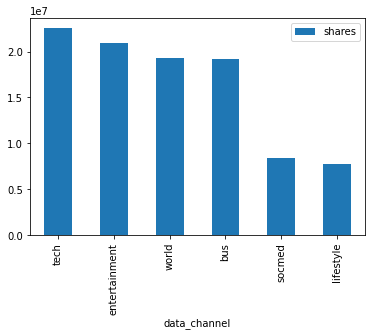

In [0]:
shares.groupby('data_channel').agg({'shares': 'sum'}).sort_values('shares', ascending=False).plot(kind='bar');



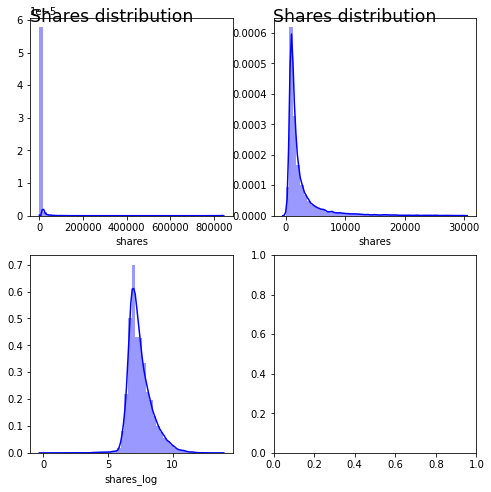

In [0]:
fig = plt.figure()
fig.set_size_inches(8,8)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.set_title("Shares distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');
ax2.set_title("Shares distribution", x=0.4, y=0.95, ha='center', fontsize='xx-large');

sns.distplot(shares.shares, bins=50, kde=True,  color='blue', ax=ax1);
shares_35k=shares.loc[shares['shares'] <= 30000]
sns.distplot(shares_35k.shares, bins=50, kde=True,  color='blue', ax=ax2);
shares['shares_log']=np.log(shares['shares'])
sns.distplot(shares.shares_log, bins=50, kde=True,  color='blue', ax=ax3);

plt.show()